In this notebook, we show how to load in and access different parts of the catalogs.

In [26]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import agama
import astropy.units as u
import astropy.coordinates as coord

agama.setUnits(mass=1, length=1, velocity=1)
timeunit_gyr = agama.getUnits()['time'].to(u.Gyr).value

The data for each halo is split up into two components: `cluster_info.hdf5` contains the orbital and mass history of the progenitor of each stream, and `stream_catalog.hdf5` contains the stars in each stream. For this example, we will use the streams from the TNG50 halo 523889. To start, let's load in both files:

In [3]:
## specify your own path to where the data are stored below
root = "/Users/cphh/astro/stream-generation-model/" 

catalog = h5py.File(root + "stream_catalog.hdf5", "r")
clusters = h5py.File(root + "cluster_info.hdf5", "r")

Each individual stream can be accessed by indexing a string integer, starting from zero up to to how many streams there are in a given halo.

In [7]:
print(catalog.keys())


<KeysViewHDF5 ['0', '1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '16', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '17', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '18', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '19', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '2', '20', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '21', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '22', '220', '221', '222', '223', '224', '225', '226', '22

We can easily check how many streams there are:

In [8]:
print(len(catalog.keys()))

289


Let's look more closely at an individual stream.

In [50]:
index = '240'

cluster = clusters[index]
stream = catalog[index]

print(cluster['mass'][:][-1])
print(cluster['age'][()]) ## empty brackets needed since this is a scalar
print(cluster['feh'][()])

22000.403319125915
12.959150168822694
-2.858


So this stream's progenitor has a mass of ~22,000 $M_{\odot}$, is about 13 Gyr old, and has a metallicity of -2.86. Let's plot its stream in $(\phi_1, \phi_2 )$ coordinates. To rotate from the native galactocentric coordinates, we can use a simple function that uses principal component analysis to rotate into the stream frame:

In [ ]:
def shift_stream_coordinates(xv_stream):
        pos = xv_stream[:,:3]

        cov = pos.T.dot(pos)

        VarOnPrincipalAxis, principalAxes = np.linalg.eig(cov) 

        # sort the principal axes in decreasing order
        ix = np.argsort(-VarOnPrincipalAxis)
        principalAxes = principalAxes[:,ix]
        VarOnPrincipalAxis = VarOnPrincipalAxis[ix]

        # Make sure the eigenvectors form a right-handed coordinate system
        if np.linalg.det(principalAxes) < 0:
            principalAxes[:,0] *= -1

        # Check that the first eigenvector is in the correct direction
        if np.sum(np.sum(principalAxes[:,0]*pos,axis=1))<0:
            principalAxes[:,0] *= -1
            principalAxes[:,1] *= -1

        
        R = principalAxes.T

        
        pos_rot = R.dot(pos.T).T

        
        phi1 = np.arctan2(pos_rot[:,1],pos_rot[:,0])
        phi2 = np.arctan2(pos_rot[:,2],np.sqrt(pos_rot[:,0]**2 + pos_rot[:,1]**2))


        return (phi1*180/np.pi)*u.deg, (phi2*180/np.pi)*u.deg



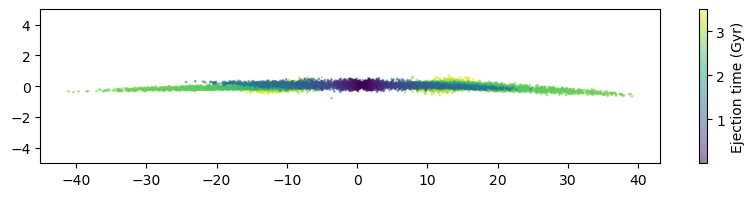

In [51]:
x = catalog[index]['x'][:]
y = catalog[index]['y'][:]
z = catalog[index]['z'][:]

vx = catalog[index]['vx'][:]
vy = catalog[index]['vy'][:]
vz = catalog[index]['vz'][:]

xv_stream = np.array([x, y, z, vx, vy, vz]).T


phi1, phi2 = shift_stream_coordinates(xv_stream)


plt.figure(figsize=(10,2))
plt.scatter(phi1, phi2, s=1, alpha=0.5, c=stream['ejection_time'][:])
plt.ylim(-5,5)
plt.colorbar(label='Ejection time (Gyr)')
plt.show()





We can also plot it in galactic coordinates (assuming the sun is located at its usual location in our TNG galaxy):

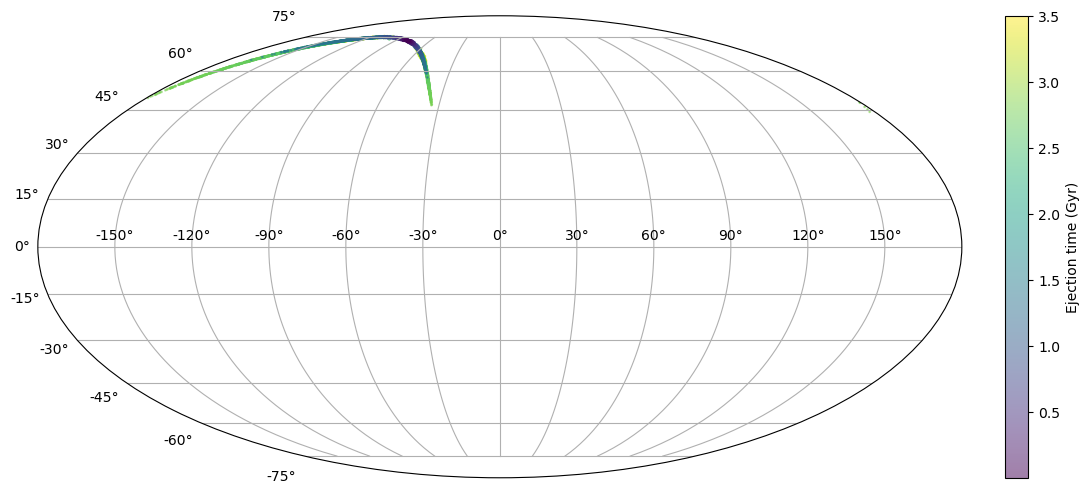

In [58]:
fig = plt.figure(figsize=(14,6))
ax = plt.subplot(projection='mollweide')
ax.grid(True)

stream_coords = coord.SkyCoord(x=x*u.kpc, y=y*u.kpc, z=z*u.kpc, v_x=vx*u.km/u.s,
                         v_y=vy*u.km/u.s, v_z=vz*u.km/u.s, frame='galactocentric')

stream_gal = stream_coords.transform_to(coord.Galactic)

img = ax.scatter(stream_gal.l.wrap_at(180*u.deg).radian, stream_gal.b.radian,
           c=stream['ejection_time'][:], s=1, alpha=0.5)

plt.colorbar(img, label='Ejection time (Gyr)', fraction=0.046, pad=0.04)
plt.show()